In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
from ijutils import format_elapsed

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
         'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

truck  deer horse  bird


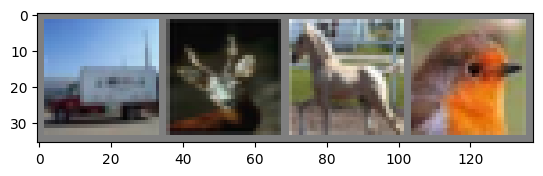

In [7]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:>5}' for j in range(4)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [11]:
start = time.perf_counter()
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2000 == 1999:
            print(f'[{epoch+1}, {i+1}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0
end = time.perf_counter()
print('Finished training in cpu')
print(f"Elapsed time : {format_elapsed(end - start)}")

[1, 2000] loss: 2.304
[1, 4000] loss: 2.302
[1, 6000] loss: 2.299
[1, 8000] loss: 2.295
[1, 10000] loss: 2.288
[1, 12000] loss: 2.275
[2, 2000] loss: 2.223
[2, 4000] loss: 2.143
[2, 6000] loss: 2.057
[2, 8000] loss: 1.960
[2, 10000] loss: 1.901
[2, 12000] loss: 1.851
Finished training in cpu
Elapsed time : 2 min 15.01 s


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += len(list(labels))
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100*correct/total}%')

Accuracy of the network on the 10000 test images: 31.82%%


In [12]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.get_device_name(0))  # Name of the first GPU

True
4
NVIDIA H100 PCIe


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
net_device = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_device.parameters(), lr=0.0001, momentum=0.9)

device: cuda


In [ ]:
start = time.perf_counter()
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_device(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i%2000 == 1999:
            print(f'[{epoch+1}, {i+1}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0
end = time.perf_counter()
print(f'Finished training in {device}')
print(f"Elapsed time : {format_elapsed(end - start)}")

[1, 6000] loss: 3.741
[1, 12000] loss: 3.738
[2, 6000] loss: 3.608
[2, 12000] loss: 3.587
[3, 6000] loss: 3.501
[3, 12000] loss: 3.470
[4, 6000] loss: 3.382
[4, 12000] loss: 3.366
[5, 6000] loss: 3.290
[5, 12000] loss: 3.254
Finished training in cuda
Elapsed time : 1 min 50.82 s


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net_device(images)
        _, predicted = torch.max(outputs.data, 1)
        total += len(list(labels))
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100*correct/total}%')

Accuracy of the network on the 10000 test images: 59.57%%
